## Demo Presentation Notebook
 This notebook presents a Demo version with most functions in the notebook reflecting how the app works. There might be small differences to the actual app for presentation purposes

In [ ]:
# Imports
import os
import base64
import json
import re
from io import BytesIO
from typing import List, Dict, Any
import numpy as np
from datetime import datetime

import pandas as pd
import requests
import torch
from IPython.display import display
from PIL import Image
from google import genai
from pinecone import Pinecone
from pydantic import BaseModel, ValidationError
from sentence_transformers import SentenceTransformer
from transformers import CLIPModel, CLIPProcessor

In [2]:
print("CUDA available:", torch.cuda.is_available())
print("Current device:", torch.cuda.current_device() if torch.cuda.is_available() else "CPU")
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

CUDA available: False
Current device: CPU
Device name: CPU


In [3]:
# Choose the Recipes 
# Test df
df = pd.read_csv("../Data/100recipes.csv")
# Full df
# df = pd.read_csv("../Data/full_dataset.csv")

## Globals:


In [ ]:
LLM_URL = "http://localhost:1234/v1/chat/completions"
IMG_URL = "http://localhost:7860/sdapi/v1/txt2img"

# LLM_MODEL = "deepseek-r1-distill-llama-8b"
LLM_MODEL = "qwen3-4b"
LLM_MODEL_SMALL = "qwen3-0.6b"
CLIP_MODEL = "openai/clip-vit-base-patch32"
EMBEDDING_MODEL = "avsolatorio/GIST-Embedding-v0"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
headers = {"Content-Type": "application/json"}

In [5]:
model_emb = SentenceTransformer(EMBEDDING_MODEL, device=DEVICE)
model_clip = CLIPModel.from_pretrained(CLIP_MODEL).to("cuda" if torch.cuda.is_available() else "cpu")
processor = CLIPProcessor.from_pretrained(CLIP_MODEL)
pc = Pinecone(api_key=PINECONE_API_KEY)
index = pc.Index("lazycook")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


## Preprocess the data:
This is how we processed the data in the beginning for embedding it with only the relevant info. The actual embedding und upserting process can be found in the scripts\recipe_embedding_P.py script.

In [6]:
# Combine relevant text fields into one string per recipe
def make_full_text(row):
    ingredients = " ".join(eval(row["NER"])) if isinstance(row["NER"], str) else ""
    directions = " ".join(eval(row["directions"])) if isinstance(row["directions"], str) else ""
    return f"{row['title']} {ingredients} {directions}"

In [7]:
df["full_text"] = df.apply(make_full_text, axis=1)

In [8]:
df.head()

,Unnamed: 0.1,Unnamed: 0,title,ingredients,directions,link,source,NER,full_text
0,0,0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu...",No-Bake Nut Cookies brown sugar milk vanilla n...
1,1,1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....",www.cookbooks.com/Recipe-Details.aspx?id=699419,Gathered,"[""beef"", ""chicken breasts"", ""cream of mushroom...",Jewell Ball'S Chicken beef chicken breasts cre...
2,2,2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...",www.cookbooks.com/Recipe-Details.aspx?id=10570,Gathered,"[""frozen corn"", ""cream cheese"", ""butter"", ""gar...",Creamy Corn frozen corn cream cheese butter ga...
3,3,3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...",www.cookbooks.com/Recipe-Details.aspx?id=897570,Gathered,"[""chicken"", ""chicken gravy"", ""cream of mushroo...",Chicken Funny chicken chicken gravy cream of m...
4,4,4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...",www.cookbooks.com/Recipe-Details.aspx?id=659239,Gathered,"[""peanut butter"", ""graham cracker crumbs"", ""bu...",Reeses Cups(Candy) peanut butter graham crac...


## Query Expansion
These two functions are used for the rag pipeline in which we expand the users query to the currect season and more food related words that might assist in finding the best recipies.

In [9]:
def get_season(date):
    """
    Determine the season based on a given date.
    
    Args:
        date (datetime): Date to check
        
    Returns:
        str: Season name ('Spring', 'Summer', 'Autumn', or 'Winter')
    """
    year = 2000  # dummy leap year to handle dates like Feb 29
    seasons = {
        'Spring': (datetime(year, 3, 20), datetime(year, 6, 20)),
        'Summer': (datetime(year, 6, 21), datetime(year, 9, 22)),
        'Autumn': (datetime(year, 9, 23), datetime(year, 12, 20)),
        'Winter': (datetime(year, 12, 21), datetime(year + 1, 3, 19))
    }

    # Replace the year in the current date with year
    current = datetime(year, date.month, date.day)
    for season, (start, end) in seasons.items():
        if start <= current <= end:
            return season
    return 'Winter'  # covers Jan 1–Mar 19

In [10]:
def get_keywords(question: str):
    """
    Get expanded keywords from LLM for a given question, including seasonal context.
    
    Args:
        question (str): The user's question about what they want to cook
        
    Returns:
        str: Comma-separated list of relevant keywords
    """
    data = {
        "model": LLM_MODEL_SMALL,
        "messages": [
            {"role": "system", "content": """You are an intelligent recipe query enrichment assistant. Your task is not to answer the user's question, but to think out loud and then output a list of highly relevant keywords related to food, cooking, ingredients, cuisines, or dish types.

    Begin your answer with a <think> block where you reason about what the user might want, and how to expand their query in a food-related context. Also take into account the current season, which is provided as a hint.

    End your answer with a comma-separated list of keywords. Do not include full sentences, explanations, or unrelated topics.

    For example:

    User: I want to eat something Italian.
    <think>
    They're probably looking for Italian food — maybe pasta, pizza, or other dishes typical of that cuisine. I will expand with some core ingredients and dish types.
    </think>
    Italian, pasta, pizza, mozzarella, tomato, olive oil, herbs, risotto

    User: {question}"

    """},
            {"role": "user", "content": f"{question}, season {get_season(datetime.now())}"},
        ],
        "temperature": 0.1,
        "max_tokens": 1024,
        "stream": False
    }

    response = requests.post(LLM_URL, headers=headers, json=data)
    print(response.json()["choices"][0]["message"]["content"])
    raw_query = response.json()["choices"][0]["message"]["content"]
    _, q_ext = raw_query.split('</think>\n\n')
    return q_ext

## Recipe creation
For the actual recipe creation we use the retrieved recipies as well as the users input and the ingredients that he has at home. After the first LLM picks and creates a first recipe, a second LLM model judges the recipe based on the users inputs and approves or disapproves with feedback for the first model.

In [11]:
# Define Pydantic model for structured output
class Recipe(BaseModel):
    """
    Pydantic class that represents a cooking recipe.

    Attributes:
        title (str): The name of the recipe.
        ingredients (List[str]): A list of ingredients required for the recipe.
        directions (List[str]): Step-by-step cooking instructions.
    """
    title: str
    ingredients: List[str]
    directions: List[str]


def generate_recipe(question: str, ingredients: str, recipes_for_llm: list, feedback: str = "") -> Recipe:
    """
    Generate a new recipe using a language model based on a question, ingredients, and top recipes.

    Args:
        question (str): The user's cooking request.
        ingredients (str): Ingredients the user has.
        recipes_for_llm (List[dict]): Top candidate recipes from the vector database.
        feedback (str, optional): Feedback from previous review to guide improvement.

    Returns:
        Recipe: Parsed and validated recipe object.
    """
    system_prompt = """You are a helpful recipe assistant. Your task is to provide a concise and relevant response based on the user's question and the ingredients they have at home.
You should return a new recipe based on the user's question and the ingredients they have, using the top recipes from a dataset.
Do not include any explanations or additional information, just the recipe details in valid JSON format. If the user specifies that he doesn't like a certain ingredient, or is allergic to it, DO NOT INCLUDE IT and replace it with something similar.

Return ONLY a JSON object in this format:
{
  "title": "...",
  "ingredients": ["..."],
  "directions": ["..."]
}
"""
    # Use a more capable model if there's feedback to incorporate
    model_to_use = LLM_MODEL if feedback else LLM_MODEL_SMALL

    if feedback:
        system_prompt += f"\nThe last recipe was rejected for the following reason: {feedback}\nMake sure to correct this in your new recipe."

    data = {
        "model": model_to_use,
        "messages": [
            {
                "role": "system",
                "content": system_prompt
            },
            {
                "role": "user",
                "content": f"question: {question}, ingredients: {ingredients}, top recipes: {recipes_for_llm}"
            }
        ],
        "temperature": 0.6,
        "max_tokens": 2048,
        "stream": False
    }

    response = requests.post(LLM_URL, headers=headers, json=data)
    content = response.json()["choices"][0]["message"]["content"]
    print("Raw model output:\n", content)

    # Extract JSON after </think>, or fallback to parsing from full content
    match = re.search(r"</think>\s*({.*})", content, re.DOTALL)
    json_block = match.group(1) if match else content.strip()

    try:
        parsed = json.loads(json_block)
        recipe = Recipe(**parsed)
        print("\nStructured recipe:")
        print(recipe)
        return recipe
    except (json.JSONDecodeError, ValidationError) as e:
        print("Error parsing or validating the recipe:\n", e)
        raise

## Recipe Reviewer

In [12]:
# Define the expected structure of the model's output
class ReviewResult(BaseModel):
    """
    Pydantic class that represents the result of reviewing a generated recipe.

    Attributes:
        approved (bool): Whether the recipe meets the user's requirements.
        ingredients_to_buy (List[str]): Ingredients the user does not have and needs to purchase.
        explanation (str): An explanation of the decision, including suggested improvements.
    """
    approved: bool
    ingredients_to_buy: List[str]
    explanation: str

# Set up the Gemini client
client = genai.Client(api_key=GOOGLE_API_KEY)

# Function to review a recipe
def review_recipe(question: str, ingredients: List[str], recipe: dict) -> ReviewResult:
    """
    Review a generated recipe for suitability and provide feedback.

    Args:
        question (str): Original user question.
        ingredients (str): Ingredients the user has.
        recipe (Recipe): The generated recipe to review.

    Returns:
        ReviewResult: Structured result indicating approval, missing ingredients, and explanation.
    """
    prompt = f"""
You are a helpful recipe reviewer assistant.

Your task is to critically assess a newly generated recipe based on the user's original cooking request and the ingredients they currently have at home.

Your responsibilities are:
1. Determine whether the recipe logically and sensibly satisfies the user's request.
2. Check for any violations of dietary preferences, allergies, or other user-stated constraints.
3. Identify which ingredients the user needs to buy to make the recipe, based on the ingredients they already have.
4. Provide a clear and constructive explanation that will help a recipe-generation assistant revise the recipe in the next step.

Important:

Do not reject a recipe just because it uses ingredients the user doesn’t currently have. New ingredients are acceptable as long as they make sense and respect the user’s request.

Your goal is not to limit the recipe to only the user's current ingredients, but to help them understand what additional ingredients are needed.

Only reject a recipe if it fails to fulfill the user’s request, includes inappropriate ingredients, or violates their stated constraints.

Return a JSON object ONLY with the following structure:

{{
  "approved": true or false,
  "ingredients_to_buy": [list of missing ingredients, empty if none],
  "explanation": A detailed and actionable explanation for improving the recipe.
}}

Explanation Guidelines:
- If the recipe violates user constraints, clearly state what those violations are and how to fix them.
- Offer suggestions such as: "remove ingredient X", "substitute ingredient Y", or "adjust cooking method Z".
- If the recipe is suitable but can be improved (e.g. it's bland, too complex, or inconsistent), note that too.
- This explanation is meant to guide another assistant model that will revise the recipe accordingly.

User question: {question}
User ingredients: {ingredients}
Recipe: {recipe}
"""


    # Call the Gemini model with structured response
    response = client.models.generate_content(
        model="gemini-1.5-flash",
        contents=prompt,
        config={
            "response_mime_type": "application/json",
            "response_schema": ReviewResult,
        },
    )

    # Get parsed response directly as a typed Pydantic object
    review_result: ReviewResult = response.parsed
    return review_result


## Recipe Review Loop

In [14]:
def generate_validated_recipe(question, ingredients, recipes_for_llm, max_attempts=3):
    """
    Generate a recipe using an LLM and validate it through iterative review.

    Args:
        question (str): The user's cooking request or query.
        ingredients (str): Ingredients the user has available.
        recipes_for_llm (List[dict]): A list of top-matching recipe candidates for context.
        max_attempts (int, optional): Maximum number of validation/revision cycles. Defaults to 3.

    Returns:
        Recipe: A valid recipe object generated by the LLM, approved through review.

    Raises:
        Exception: If no valid recipe can be generated after all attempts.
    """
    attempt = 0
    last_explanation = ""
    recipe = None 

    while attempt < max_attempts:
        try:
            # Pass the previous explanation (if any) as feedback to improve the recipe
            print(last_explanation)
            recipe = generate_recipe(question, ingredients, recipes_for_llm, feedback=last_explanation)

            review_result = review_recipe(question, ingredients, recipe)

            if review_result.approved:
                print("Recipe approved!")
                return recipe
            else:
                print(f"Recipe not approved (Explanation: {review_result.explanation}).")
                last_explanation = review_result.explanation
                attempt += 1
        except Exception as e:
            print(f"Error generating recipe: {e}")
            attempt += 1

    # Check if we have a recipe to return, otherwise try one final time without feedback
    if recipe is not None:
        print("Reached max attempts. Proceeding with the last generated recipe.")
        return recipe
    else:
        print("All attempts failed. Trying one final time without feedback...")
        try:
            recipe = generate_recipe(question, ingredients, recipes_for_llm, feedback="")
            return recipe
        except Exception as e:
            raise Exception(f"Failed to generate any recipe after maximum attempts: {e}")

## Image prompt
For the image creation we use another LLM call to get a fitting prompt for the created recipe. In the review process three images are created and based on a calculated CLIP model accuracy the best of the three is choosen for final display. 

In [15]:
def get_prompt(question):
    """
    Generate a stylized image prompt for a dish using a language model.

    Args:
        question (str): Textual description of the recipe or dish.

    Returns:
        str: A cleaned positive prompt string suitable for use with image generation models.
    """
    headers = {"Content-Type": "application/json"}

    system_prompt = """You are a helpful AI Assistant.
You write prompts for Stable Diffusion image generation, focused exclusively on food as the main subject.

Rules to follow:

Do NOT include kitchens, cooking tools, utensils, tables, people, or any detailed background elements.

Use only simple, neutral, or minimal backgrounds (e.g. plain color, subtle texture).

The food should be the centerpiece, placed clearly on a single plate or dish. No multiple plates or extra items.

Style must be a drawing or painting, NOT photorealistic. Emphasize illustration quality (e.g., watercolor, gouache, pencil sketch, digital painting, etc.).

Format:

Positive prompt: a [style] drawing/painting of [dish/food item], with [visual details: shape, texture, colors], on a single plate, on a simple background, [mood or lighting if relevant]

Example:

Positive prompt: a watercolor painting of a slice of strawberry cheesecake, creamy texture with bright red strawberries on top, on a white ceramic plate, placed on a soft beige background, warm and inviting"""

    data = {
        "model": LLM_MODEL_SMALL,
        "messages": [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": question}
        ],
        "temperature": 0.1,
        "max_tokens": 1024,
        "stream": False
    }

    response = requests.post(LLM_URL, headers=headers, json=data)
    answer = response.json()["choices"][0]["message"]["content"].strip()

    if "</think>" in answer:
        clean_answer = answer.split("</think>")[-1].strip()
    else:
        clean_answer = answer.strip()

    print(clean_answer)

    prompt = clean_answer.replace("Positive prompt:", "").strip()
    return prompt


## Image Generation

In [16]:
# Send request
def create_image(prompt):
    """
    Generate an image from a text prompt using a text-to-image generation API.

    Args:
        prompt (str): Text description of the image to generate.

    Returns:
        Image.Image: The generated image as a PIL Image object.
    """
    payload = {
        "prompt": prompt,
        "negative_prompt": "blurry, low resolution, watermarks, text, logo, signature, bad anatomy, bad hands, bad proportions, ugly, duplicate, morbid, mutilated, out of frame, extra digit, fewer digits, cropped, worst quality, low quality",
        "steps": 30,
        "cfg_scale": 7,
        "width": 1024,
        "height": 512,
        "sampler_name": "Euler a",  # or "DPM++ 2M Karras", etc.
        "seed": -1  # -1 means random
    }

    response = requests.post(IMG_URL, json=payload)
    result = response.json()

    # Decode the image
    image_base64 = result['images'][0]
    image_bytes = base64.b64decode(image_base64)
    image = Image.open(BytesIO(image_bytes))

    # Display inline in Jupyter
    # display(image)
    return image


## Image to text similarity and review loop

In [17]:
def compute_similarity(image: Image.Image, text: str) -> float:
    """
    Compute the cosine similarity between an image and a text description using CLIP.

    Args:
        image (PIL.Image.Image): The image to evaluate.
        text (str): The textual description or prompt.

    Returns:
        float: A similarity score between the text and image embeddings.
               Higher values indicate greater similarity.
    """
    inputs = processor(
        text=[text], 
        images=image, 
        return_tensors="pt", 
        padding=True, 
        truncation=True,
        max_length=77
    )
    inputs = {k: v.to(model_clip.device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model_clip(**inputs)
        image_embeds = outputs.image_embeds
        text_embeds = outputs.text_embeds
    image_embeds = image_embeds / image_embeds.norm(p=2, dim=-1, keepdim=True)
    text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)
    similarity = torch.matmul(text_embeds, image_embeds.T).item()
    return similarity


In [18]:
# Pipeline
def image_pipeline(recipe, num_iterations=3):
    """
    Generate multiple food images from a recipe prompt and select the best one based on similarity.

    Args:
        recipe (str): A textual description of a food item or dish.
        num_iterations (int, optional): Number of images to generate and evaluate. Defaults to 3.

    Returns:
        None. The function displays the best-matching image based on text-image similarity.
    """
    prompt = get_prompt(recipe)
    similarity_scores = []
    images = []
    for i in range(num_iterations):
        image = create_image(prompt)
        similarity_score = compute_similarity(image, recipe)
        print(f"Iteration {i+1} - Similarity: {similarity_score:.4f}")
        similarity_scores.append(similarity_score)
        images.append(image)

    similarity_scores.sort(reverse=True)
    best_image = images[similarity_scores.index(max(similarity_scores))]
    print("Best image based on similarity score:")
    display(best_image)

## Rag

In [19]:
def rag_recipes(question: str, ingredients: str, index: Pinecone, top_k: int = 3) -> list:
    """
    Search for similar recipes using question and ingredients as query.
    
    Args:
        question (str): User's question about what they want to cook
        ingredients (str): Available ingredients
        index (Pinecone): Pinecone index instance
        top_k (int): Number of similar recipes to return
    
    Returns:
        list: List of dictionaries containing recipe metadata
    """
    # Step 1: Enrich the query
    q_ext = get_keywords(question)
    query_text1 = question + " " + ingredients
    query_text2 = q_ext

    # Step 2: Embed the enriched query
    query_vector1 = model_emb.encode(query_text1, show_progress_bar=False).tolist()
    query_vector2 = model_emb.encode(query_text2, show_progress_bar=False).tolist()

    query_vector = (0.7 * np.array(query_vector1) + 0.3 * np.array(query_vector2)).tolist()

    # Step 3: Search Pinecone
    results = index.query(
        vector=query_vector,
        top_k=top_k,
        namespace="recipes-namespace",
        include_metadata=True
    )

    # Step 4: Format results
    recipes_for_llm = []
    for match in results["matches"]:
        metadata = match["metadata"]
        recipes_for_llm.append({
            "title": metadata.get("title", ""),
            "ingredients": metadata.get("ingredients", ""),
            "directions": metadata.get("directions", "")
        })

    return recipes_for_llm


## Function Calling
This is how the main app will call the created helper functions and pipelines

In [20]:
question = input("What would you like to cook? ")
ingredients = input("What Ingredients do you have at home?: ")

In [21]:
recipes_for_llm = rag_recipes(question, ingredients, index = index, top_k=5)

<think>
Okay, the user mentioned Indian cuisine and summer. So, I need to think about what Indian dishes are popular during summer. Common summer recipes often include things like curries, samosas, or paneer. The keywords should be related to Indian food and summer.

I should consider seasonings, spices, and common ingredients in Indian dishes that might be suitable for a summer meal. Maybe include some seasonal elements like tomatoes or coconut oil, which are popular in Indian cooking. 

The user also provided the keyword "season" which is important here. So I'll list those as part of the keywords. Let me make sure I'm not missing anything and that the answer includes those key points.
</think>

Indian, summer, curry, paneer, tomato, coconut, spices, herbs, olive oil, butter, rice


In [22]:
recipes_for_llm

[{'title': 'A Very Anglo-Indian Egg Curry',
  'ingredients': '["6 medium eggs", "400 g potatoes, cut into medium dice", "1 teaspoon coriander seed", "1 teaspoon cumin seed", "3 cardamom pods, seeds of", "1/2 teaspoon ground ginger", "1/2 teaspoon ground turmeric", "1/4 teaspoon crushed dried chili", "15 g butter", "1 tablespoon olive oil", "3 garlic cloves, chopped", "2 medium onions, finely diced", "3 celery ribs, finely diced", "2 tablespoons passata", "284 ml double cream", "coriander leaves, to garnish"]',
  'directions': '["Cook eggs in boiling water 8 minutes. Drain and cool slightly, then shell and set aside.", "Cook potatoes in boiling salted water 6 minutes or until tender but not falling apart. Drain and set aside.", "Grind coriander, cumin and cardamom seeds in a pestle and mortar and mixt with the ginger, turmeric and chilli.", "Heat a large deep frying pan over medium heat and dry fry spices 1 minute. Add butter and oil, then garlic, onions and celery. Fry 10-12 minutes un

In [23]:
final_recipe = generate_validated_recipe(question, ingredients, recipes_for_llm)


Raw model output:
 <think>
Okay, the user wants a recipe based on their ingredients: eggs, potato, wheat, rice. The top recipes mentioned are Indian curry. Let me check which of these would fit their ingredients.

The first recipe is "A Very Anglo-Indian Egg Curry" with all the required items: eggs, potatoes, coriander seed, cumin seed, turmeric, ginger, butter, olive oil, garlic, onions, etc. That matches their ingredients and directions.

So I should use that as the title, and include all the listed ingredients from the dataset. The directions provided by the top recipe would work too. Let me make sure to list all the required items they have at home, which are eggs, potatoes, wheat, rice. 

Wait, the user specified "wheat", so I need to check if that's an ingredient or a typo. Wheat might be a different spice or flour instead of turmeric. But since the directions don't mention wheat, maybe it's a mistake. However, as per the dataset, the ingredients include coriander seed and cumin

a digital painting of an Anglo-Indian egg curry, featuring six medium eggs, four hundred grams of potatoes, and a warm, inviting mood, placed on a white ceramic plate with a soft beige background. The style is a watercolor or pencil sketch, emphasizing simplicity and natural textures.
Iteration 1 - Similarity: 0.2447
Iteration 2 - Similarity: 0.2878
Iteration 3 - Similarity: 0.3076
Best image based on similarity score:


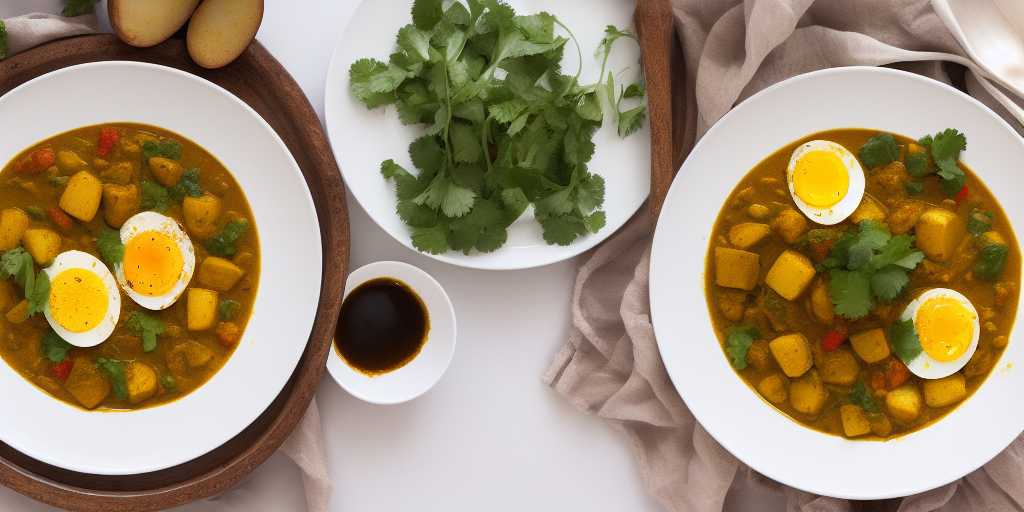

In [25]:
image = image_pipeline(f"{final_recipe.title} with {', '.join(final_recipe.ingredients)}")

# Shopping list Agent
After the Recipe and Image are created, we wanted to give the user the option to directly add missing ingredients to his existing shopping list. For that purpose we call an agent that has acess to multiple functions to check the current shopping list and add/delete items. In the actual app the agent will be called with the missing ingredients as an input, once the user approved the recipe.
Currently the shopping_list is just a .txt file. In the future this could possibly get connected to the users cloud hosted documents like google docs or a different cloud hosted app.

In [ ]:
import google.generativeai as genai

# ── 0.  Configure SDK ───────────────────────────────────────────────────────────
genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))

SHOPPING_LIST_FILE = "../shopping_list.txt"

def load_shopping_list() -> list:
    if os.path.exists(SHOPPING_LIST_FILE):
        with open(SHOPPING_LIST_FILE, "r", encoding="utf-8") as f:
            return [line.strip() for line in f if line.strip()]
    return []

def save_shopping_list(shopping_list: list):
    with open(SHOPPING_LIST_FILE, "w", encoding="utf-8") as f:
        for item in shopping_list:
            f.write(item + "\n")

# ── 1.  Persistent state (saved to file) ───────────────────────────────────────
shopping_list: list[str] = load_shopping_list()

# ── 2.  Enhanced Python functions ─────────────────────────────────────────────
def get_shopping_list() -> dict:
    """Return current items."""
    return {"shopping_list": shopping_list}

def add_items(items: list[str]) -> dict:
    """Add items, ignoring duplicates."""
    added = []
    for i in items:
        if i not in shopping_list:
            shopping_list.append(i)
            added.append(i)
    save_shopping_list(shopping_list)
    return {"shopping_list": shopping_list, "added": added}

def remove_items(items: list[str]) -> dict:
    """Remove items that exist; ignore unknowns."""
    removed = []
    for i in items:
        if i in shopping_list:
            shopping_list.remove(i)
            removed.append(i)
    save_shopping_list(shopping_list)
    return {"shopping_list": shopping_list, "removed": removed}

def update_item_quantity(item: str, new_quantity: str) -> dict:
    """Update quantity of an existing item or add new item with quantity."""
    # Find existing item (case-insensitive, partial match)
    existing_item = None
    for existing in shopping_list:
        if item.lower() in existing.lower() or existing.lower() in item.lower():
            existing_item = existing
            break
    
    if existing_item:
        shopping_list.remove(existing_item)
        shopping_list.append(f"{new_quantity} {item}")
        save_shopping_list(shopping_list)
        return {"shopping_list": shopping_list, "updated": f"{existing_item} -> {new_quantity} {item}"}
    else:
        shopping_list.append(f"{new_quantity} {item}")
        save_shopping_list(shopping_list)
        return {"shopping_list": shopping_list, "added": f"{new_quantity} {item}"}

def check_items_exist(items: list[str]) -> dict:
    """Check which items already exist on the shopping list."""
    existing = []
    missing = []
    
    for item in items:
        found = False
        for existing_item in shopping_list:
            if item.lower() in existing_item.lower() or existing_item.lower() in item.lower():
                existing.append({"requested": item, "existing": existing_item})
                found = True
                break
        if not found:
            missing.append(item)
    
    return {"existing": existing, "missing": missing, "shopping_list": shopping_list}

# Look-up table the agent will use after Gemini suggests a function call
PY_FUNCS = {
    "get_shopping_list": get_shopping_list,
    "add_items": add_items,
    "remove_items": remove_items,
    "update_item_quantity": update_item_quantity,
    "check_items_exist": check_items_exist,
}

# ── 3.  Enhanced function declarations for Gemini ─────────────────────────────────
function_declarations = [
    genai.protos.FunctionDeclaration(
        name="get_shopping_list",
        description="Returns the current items on the shopping list.",
        parameters=genai.protos.Schema(
            type=genai.protos.Type.OBJECT,
            properties={}
        )
    ),
    genai.protos.FunctionDeclaration(
        name="check_items_exist",
        description="Check which items from a list already exist on the shopping list. Use this first before adding items.",
        parameters=genai.protos.Schema(
            type=genai.protos.Type.OBJECT,
            properties={
                "items": genai.protos.Schema(
                    type=genai.protos.Type.ARRAY,
                    items=genai.protos.Schema(type=genai.protos.Type.STRING),
                    description="Items to check for existence"
                )
            },
            required=["items"]
        )
    ),
    genai.protos.FunctionDeclaration(
        name="add_items",
        description="Add one or more items to the shopping list.",
        parameters=genai.protos.Schema(
            type=genai.protos.Type.OBJECT,
            properties={
                "items": genai.protos.Schema(
                    type=genai.protos.Type.ARRAY,
                    items=genai.protos.Schema(type=genai.protos.Type.STRING),
                    description="Items to add"
                )
            },
            required=["items"]
        )
    ),
    genai.protos.FunctionDeclaration(
        name="remove_items",
        description="Remove one or more items from the shopping list.",
        parameters=genai.protos.Schema(
            type=genai.protos.Type.OBJECT,
            properties={
                "items": genai.protos.Schema(
                    type=genai.protos.Type.ARRAY,
                    items=genai.protos.Schema(type=genai.protos.Type.STRING),
                    description="Items to remove"
                )
            },
            required=["items"]
        )
    ),
    genai.protos.FunctionDeclaration(
        name="update_item_quantity",
        description="Update the quantity of an existing item or add a new item with specific quantity.",
        parameters=genai.protos.Schema(
            type=genai.protos.Type.OBJECT,
            properties={
                "item": genai.protos.Schema(
                    type=genai.protos.Type.STRING,
                    description="The item name"
                ),
                "new_quantity": genai.protos.Schema(
                    type=genai.protos.Type.STRING,
                    description="The new quantity (e.g., '2 loaves of', '1 gallon of', '3 lbs')"
                )
            },
            required=["item", "new_quantity"]
        )
    ),
]

# ── 4.  React Agent System Prompt ─────────────────────────────────────────────────
REACT_SYSTEM_PROMPT = """
You are a smart shopping list agent that can perform multiple actions to intelligently manage a shopping list. 

When a user gives you ingredients or items, you should:
1. FIRST check what's already on the shopping list using check_items_exist()
2. THEN decide what actions to take based on what you find:
   - If items already exist but user wants different quantities, use update_item_quantity()
   - If items don't exist, use add_items()
   - If user wants to remove items, use remove_items()
3. ALWAYS explain what actions you took and why

You can call multiple functions in sequence to accomplish complex tasks. Think step by step and be proactive about checking existing items before making changes.

Key behaviors:
- Always check existing items first before adding
- Be smart about partial matches (e.g., "bread" matches "2 loaves of bread")
- Update quantities when appropriate rather than adding duplicates
- Provide clear explanations of what you did
- Handle multiple items in one request efficiently
"""

def react_agent(user_text: str, history: list = None):
    """
    Enhanced agent that can perform multiple actions intelligently.
    Uses React-style reasoning: Reason -> Act -> Observe -> Reason -> Act...
    """
    if history is None:
        history = []

    # Create the model with system prompt
    model = genai.GenerativeModel(
        'gemini-1.5-flash',
        tools=[genai.protos.Tool(function_declarations=function_declarations)],
        system_instruction=REACT_SYSTEM_PROMPT,
        generation_config=genai.GenerationConfig(
            temperature=0.2,
        )
    )

    # Start chat with history
    chat = model.start_chat(history=history)

    # Send user message
    response = chat.send_message(user_text)
    
    # Keep track of function calls for debugging
    function_calls_made = []
    
    # Continue conversation until no more function calls
    while True:
        # Check if model wants to call functions
        function_calls = []
        if response.candidates[0].content.parts:
            for part in response.candidates[0].content.parts:
                if part.function_call:
                    function_calls.append(part.function_call)
        
        if function_calls:
            # Execute all function calls and prepare responses
            function_responses = []
            
            for function_call in function_calls:
                func_name = function_call.name
                func_args = dict(function_call.args)
                
                print(f"Agent calling: {func_name}({func_args})")
                function_calls_made.append(f"{func_name}({func_args})")

                # Execute the function
                result = PY_FUNCS[func_name](**func_args)
                print(f"Result: {result}")

                # Create function response
                function_response = genai.protos.Part(
                    function_response=genai.protos.FunctionResponse(
                        name=func_name,
                        response={"result": result}
                    )
                )
                function_responses.append(function_response)

            # Send all function responses back to model
            response = chat.send_message(function_responses)
            
        else:
            # No more function calls, return final response
            break
    
    final_text = response.text
    print(f"\nFinal Response: {final_text}")
    if function_calls_made:
        print(f"Functions called: {' -> '.join(function_calls_made)}")
    
    return final_text, chat.history

# ── 5.  Enhanced Demo ───────────────────────────────────────────────────────────────
if __name__ == "__main__":
    print("🛒 Smart Shopping List Agent Demo")
    print("=" * 50)
    
    chat_history = []
    
    # Demo 1: Check what's on the list
    print("\n1. Checking current shopping list...")
    _, chat_history = react_agent("What's on my shopping list?", chat_history)
    
    # Demo 2: Add some items intelligently
    print("\n2. Adding ingredients for pasta dinner...")
    _, chat_history = react_agent("I want to make pasta dinner. I need pasta, tomato sauce, ground beef, parmesan cheese, and garlic bread", chat_history)
    
    # Demo 6: Show final list
    print("\n6. Final shopping list...")
    _, chat_history = react_agent("Show me the final shopping list", chat_history)

🛒 Smart Shopping List Agent Demo

1. Checking current shopping list...
🤖 Agent calling: get_shopping_list({})
📊 Result: {'shopping_list': ['bananas', 'two loaves of bread', '2 pounds of ground beef', '3 boxes of pasta']}

🎯 Final Response: Your shopping list currently contains: bananas, two loaves of bread, 2 pounds of ground beef, and 3 boxes of pasta.

📋 Functions called: get_shopping_list({})

2. Adding ingredients for pasta dinner...
🤖 Agent calling: check_items_exist({'items': ['pasta', 'tomato sauce', 'ground beef', 'parmesan cheese', 'garlic bread']})
📊 Result: {'existing': [{'requested': 'pasta', 'existing': '3 boxes of pasta'}, {'requested': 'ground beef', 'existing': '2 pounds of ground beef'}], 'missing': ['tomato sauce', 'parmesan cheese', 'garlic bread'], 'shopping_list': ['bananas', 'two loaves of bread', '2 pounds of ground beef', '3 boxes of pasta']}

🎯 Final Response: OK. I see that you already have 3 boxes of pasta and 2 pounds of ground beef on your list.  I've added

In [4]:
import importlib.metadata, google.generativeai as genai
print(importlib.metadata.version("google-generativeai"))  # 0.8.5  ← OK

0.8.5
